In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import pickle
import ComplexNetworks as CN
import os
import matplotlib.cm as cm
import networkx as nx
from scipy import stats
import operator
import itertools

def readERA5(min_lat=20):
    if os.path.exists(home+'/DATA/ERA5_DJFM_SLP.nc')==False:
        import cdsapi

        c = cdsapi.Client()
        dates = np.arange(1979,2020+1)
        c.retrieve(
            'reanalysis-era5-single-levels-monthly-means',
            {
                'format': 'netcdf',
                'product_type': 'monthly_averaged_reanalysis',
                'variable': 'mean_sea_level_pressure',
                'year': [str(date) for date in dates],
                'month': ['01','02','03','12'],
                'time': '00:00',
                'grid':'4/2',
                'area': [
                    90, -180, min_lat,
                    180,
                ],
            },
            home+'/DATA/ERA5_DJFM_SLP.nc')

    SLP = {}
    file = Dataset(home+'/DATA/ERA5_DJFM_SLP.nc')
    SLP['lon'],SLP['lat'] = np.meshgrid(np.arange(-180,180,4),np.arange(90,18,-2))
    data = (np.array(file['msl']).transpose(1,2,0)).reshape(36,90,4,2020-1979+1,order='F')
    data[-1,:,:,:] = np.nan #at least 1 grid cell required to be nan for networks analysis (still need to fix this)
    DJFM = np.zeros((36,90,2020-1979+1))
    for year in range(1979,2020+1):
        if year == 1979:
            DJFM[:,:,year-1979] = np.nanmean([data[:,:,0,year-1979],data[:,:,1,year-1979],data[:,:,2,year-1979]],0)
        else:
            DJFM[:,:,year-1979] = np.nanmean([data[:,:,3,year-1979-1],data[:,:,0,year-1979],data[:,:,1,year-1979],data[:,:,2,year-1979]],0)
    SLP['DJFM'] = DJFM
    return SLP

def detrend(dataset):
    data = dataset['DJFM']
    X = data.shape[0] ; Y = data.shape[1]
    nmax = data.shape[2]-1
    detrended = np.zeros(data.shape)*np.nan
    for i,j in itertools.product(range(X),range(Y)):
        if (~np.isnan(data[i,j,range(nmax+1)])).all():
            trendT, interceptT, r_valsT, probT, stderrT = stats.linregress(np.arange(nmax+1),data[i,j,range(nmax+1)])
            lineT = (trendT*np.arange(nmax+1)) + interceptT
            detrended[i,j,range(nmax+1)]=data[i,j,range(nmax+1)]-lineT

    dataset['dt'] = detrended
        
def networks(dataset):
    data = dataset['dt']
    network = CN.Network(data)
    CN.Network.get_threshold(network)
    CN.Network.get_nodes(network, latlon=True)
    CN.Network.get_links(network, lat=dataset['lat'])
    dataset['nodes'] = network.nodes
    dataset['anoms'] = network.anomaly
    dataset['links'] = network.links
    dataset['strength'] = network.strength
    dataset['strengthmap'] = network.strengthmap
        
def save(dataset,path):
    f = open(path,'wb')
    pickle.dump(dataset,f)
    f.close()

    
home = os.getcwd()
if os.path.exists(home+'/DATA')==False:
    os.mkdir(home+'/DATA')
    os.chmod(home+'/DATA',0o0777)

m = Basemap(projection='npstere',boundinglat=20,lon_0=360,resolution='l')

SLP = readERA5()
detrend(SLP)
networks(SLP)
save(SLP,home+'/DATA/ERA5_psl_network_historical.pkl')

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ComplexNetwor

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in e

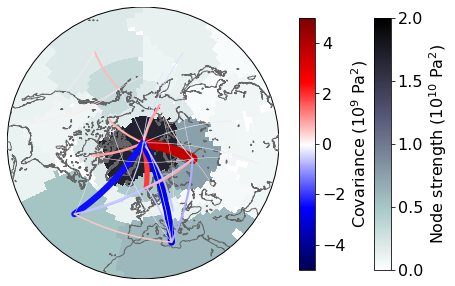

In [5]:
def nodepos(nodes,node,dY=90):
    xpts = np.array([n[0] for n in nodes[node]])
    ypts = np.array([n[1] for n in nodes[node]])
    if (0 in ypts) & (dY-1 in ypts):
        mode = stats.mode(ypts)[0][0]
        dists = [np.sqrt((0 - mode)**2),np.sqrt((dY-1 - mode)**2)]
        maxdist = dists.index(max(dists))
        if maxdist == 0:
            ypts[ypts<10] = ypts[ypts<10] + dY
        else:
            ypts[ypts>45] = ypts[ypts>45] - dY
    return int(round(np.mean(xpts))),int(round(np.mean(ypts)))

def makegraph(dataset,key='',product='',significance=0.10):
    graph = nx.DiGraph(directed=False)
    unavail = []
    unavail2 = []
    edges = []
    mapper1 = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-5e9, vmax=5e9), cmap=cm.seismic)
    mapper2 = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=2e10), cmap=cm.bone_r)
    df = dataset[key+'dt'].shape[2] - 2
    for node1 in dataset[key+'nodes']:
        if node1 == 0:
            lon1,lat1 = 0,90
            x1,y1 = m(lon1,lat1)
        else:
            p,q = nodepos(dataset[key+'nodes'],node1)
            lon1,lat1 = m(x[p,q],y[p,q],inverse=True)
            x1,y1 = x[p,q],y[p,q]
        if (node1 not in unavail) & (lat1>22):
            graph.add_node(node1, pos=(x1,y1), color='black', size=0)
            unavail.append(node1)
        k = 0
        for node2 in dataset[key+'nodes']:
            p,q = nodepos(dataset[key+'nodes'],node2)
            lon2,lat2 = m(x[p,q],y[p,q],inverse=True)
            if (node2 not in unavail) & (lat2>22):
                graph.add_node(node2, pos=(x[p,q],y[p,q]), color='black', size=0)
                unavail.append(node2)
            edge = dataset[key+'links'][node1][k]
            R = edge/(np.std(dataset[key+'anoms'][node1])*np.std(dataset[key+'anoms'][node2]))
            tval = R*np.sqrt(df/(1 - R**2))
            P = stats.t.sf(abs(tval),df)
            if (P<significance) & (node1 != node2) & (node1 in graph.nodes()) & (node2 in graph.nodes()) & \
                    ([node2,node1] not in unavail2) & ([node1,node2] not in unavail2):
                if edge > 0:
                    graph.add_weighted_edges_from([(node1,node2,edge)], color=mapper1.to_rgba(edge), style='solid') 
                if edge < 0:
                    graph.add_weighted_edges_from([(node1,node2,abs(edge))], color=mapper1.to_rgba(edge), style='solid')
                unavail2.append([node1,node2])
                unavail2.append([node2,node1])
                edges.append(edge)
            k += 1

    edges = graph.edges()
    nodes = graph.nodes()
    node_size = [nx.get_node_attributes(graph, 'size')[n] for n in nodes]
    node_color = [mapper2.to_rgba(dataset[key+'strength'][n]) for n in nodes]
    edge_color = [graph[u][v]['color'] for u,v in edges]
    edge_style = [graph[u][v]['style'] for u,v in edges]
    weights = [graph[u][v]['weight'] for u,v in edges]
    minw = min(weights) ; maxw = max(weights)
    mw = max(abs(minw),abs(maxw))
    weights_scale = [(i/mw)*10 for i in weights]

    return graph,node_size,node_color,edge_color,weights_scale


lon,lat = np.meshgrid(np.arange(-180,184,4),np.arange(90,18,-2))
x,y = m(lon,lat)
graph = makegraph(SLP,product='era5')

fig,ax = plt.subplots(1,figsize=(5,5))
weights = np.array(graph[4])
weights[weights<0.4] = 0

m = Basemap(projection='npstere',boundinglat=20,lon_0=360,ax=ax,resolution='l',round=True)
s = m.pcolormesh(x,y,SLP['strengthmap']/1e10,cmap=cm.bone_r,rasterized=True,vmin=0,vmax=2)
m.drawcoastlines(linewidth=1,color=(0.4,0.4,0.4))
gs = nx.draw_networkx_nodes(graph[0], pos=nx.get_node_attributes(graph[0], 'pos'), node_size=graph[1], node_color=graph[2],\
    edge_style='solid',edge_color=graph[3], width=list(weights), connectionstyle='arc3,rad=-0.1',arrowstyle='-',ax=ax)
es = nx.draw_networkx_edges(graph[0], pos=nx.get_node_attributes(graph[0], 'pos'), node_size=graph[1], node_color=graph[2],\
    edge_style='solid',edge_color=graph[3], width=list(weights), connectionstyle='arc3,rad=-0.1',arrowstyle='-',ax=ax)
for key in es:
    key.set_zorder(20)
    
p0 = ax.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[1]+0.82, 0.15, p0[1]-0.08, 0.70])
sm = plt.cm.ScalarMappable(cmap=cm.seismic, norm=plt.Normalize(vmin=-5, vmax=5))
cbar1 = fig.colorbar(sm, cax=ax_cbar)
cbar1.solids.set_rasterized(True)
cbar1.set_label('Covariance (10$^9$ Pa$^2$)',fontsize=16)
cbar1.solids.set_edgecolor("face")
cbar1.ax.tick_params(labelsize=16)
ax_cbar = fig.add_axes([p0[1]+1.03, 0.15, p0[1]-0.08, 0.70])
cbar2 = fig.colorbar(s, cax=ax_cbar)
cbar2.solids.set_rasterized(True)
cbar2.set_label('Node strength (10$^{10}$ Pa$^2$)',fontsize=16)
cbar2.solids.set_edgecolor("face")
cbar2.ax.tick_params(labelsize=16)

plt.show()